<a href="https://colab.research.google.com/github/jollygoodjacob/NASA_SpaceApps_Workshop_2024/blob/main/NASA_SpaceApps_Workshop_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA SpaceApps Workshop 2024

## Downloading NASA spatial datasets from NASA Earthdata
In this tutorial, you will learn how to download NASA datasets through NASA Earthdata and the earthaccess Python API. We will demonstrate the earthaccess API's use through an exploration of 30m elevation data from the Shuttle Radar Topography Mission (SRTM) over the Russian River watershed.

### Sign up for NASA Earthdata
For many of the challenges, NASA Earthdata will be pivotal for obtaining data from NASA that pertains to your challenge. NASA’s Earthdata is your gateway to one of the planet’s largest repositories of Earth observation data. These data – along with the tools for analyzing and working with these data – are available to you fully, openly, and without restriction.

Just follow these simple steps to create an Earthdata Login for yourself.

1. Go to the Earthdata Login web site, and click on the 'Register' button
2. Enter your information. Only a few fields are mandatory, and these are marked clearly with red dots.
3. Once you have entered your details, click on the green 'Register for Earthdata Login' button at the bottom.
4. To complete the registration, you will now need to go to your email inbox and look for an email similar to the email below. You can activate your account by clicking the activation link provided in the email. Your account must be active before you can login.
5. The link provided in the email should redirect you to NASA Earthdata's activation page. You have now successfully activated your earthdata login account.


### Import required packages
To begin, we need to install a few packages into our Google Colab session prior to running through the tutorial.

In [ ]:
!pip install earthaccess
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 57.8 MB/s eta 0:00:00


Next, we will want to import the necessary packages.

In [ ]:
# Import Required Packages
import os
import earthaccess
import geopandas as gpd
import rasterio as rio
import rasterio.merge
import shapely

### Prepare a search area

While there are many ways to search for data through the earthaccess API, one effective way to search for data is to predefine an area of interest or study extent. Then, we can search for relevant data to our study.

We can use a combination of geometric operations to obtain a simple outline of our data, which can be used for the search, and to help filter and refine our search results.

First, we’ll load the data using geopandas, making sure to transform from the original CRS to WGS84 latitude/longitude (epsg=4326):

In [ ]:
russian_huc8 = gpd.read_file("https://raw.githubusercontent.com/jollygoodjacob/NASA_SpaceApps_Workshop_2024/master/russian_huc8.shp").to_crs(epsg=4326)

<ipython-input-15-a1755416d225>:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  outline = russian_huc8['geometry'].unary_union


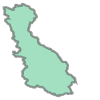

In [ ]:
# gets a single polygon (or multipolygon) composed of the individual polygons
outline = russian_huc8['geometry'].unary_union
outline

We often want to simplify our polygon prior to use in NASA Earthdata (or most APIs), as they tend to not like complex geometries.

We can  obtain the spatial extent of the shapefile using the .bounds command. However, we can also pass a polygon argument. Rather than pass the outline (a very complicated geometric object), though, we’ll look at one additional attribute of a shapely Polygon that we can use to get a bounding box of the geometry - the minimum_rotated_rectangle (documentation) Then, from these coordinates, we can create a rectangle that specifies the minimum extent encompassing our shapefile of the Russian River.

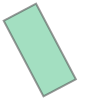

In [ ]:
outline.bounds # get the min x, min y, max x, max y values of the polygon

# gets the minimum rotated rectangle that covers the outline
search_area = outline.minimum_rotated_rectangle

search_area # again, in a jupyter notebook, this displays the polygon

The API that earthaccess uses requires that the Polygon be oriented counter-clockwise. To do this, we can use shapely.geometry.polygon.orient()

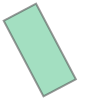

In [ ]:
search_area = shapely.geometry.polygon.orient(search_area, sign=1) # a sign of 1 means oriented counter-clockwise

search_area # this doesn't actually change the geometry, just the order of the vertices

### Searching NASA Earthdata for imagery

In [ ]:

auth = earthaccess.login(strategy="interactive", persist=True)

# Thanks to NSIDC for the earthaccess package. See https://github.com/nsidc/earthaccess
# for more details.

Enter your Earthdata Login username: jneslage@ucmerced.edu
Enter your Earthdata password: ··········


For this example, we’ll use the following arguments for the search:

**short_name:** the dataset short name. For a full list of available datasets, check the LPDAAC Data Catalog

**polygon:** a list of (lon, lat) tuples to use for spatial filtering

**count:** the maximum number of search results to return

To see what additional arguments are available, you can check the GranuleQuery API reference for additional keywords to use, based on the listed methods for the GranuleQuery class.

In [ ]:
results = earthaccess.search_datasets(
    keyword="NASADEM_HGT v001", # search for STRM 30m v21 granules
    polygon=search_area.exterior.coords#, # search for images that intersect our search_area
    #count=10 # only show the first 10 results
)

In [ ]:
len(results) # show the length of the results list

1

In [ ]:
granule = next(iter(results)) # get the "first" item from the list
granule # show the first item

{
  "meta": {
    "revision-id": 16,
    "deleted": false,
    "format": "application/vnd.nasa.cmr.umm+json",
    "provider-id": "LPCLOUD",
    "has-combine": false,
    "user-id": "keinerjones",
    "has-formats": false,
    "associations": {
      "variables": [
        "V3219987629-LPCLOUD",
        "V3219987724-LPCLOUD",
        "V3219987771-LPCLOUD"
      ]
    },
    "s3-links": [
      "s3://lp-prod-protected/NASADEM_HGT.001",
      "s3://lp-prod-public/NASADEM_HGT.001"
    ],
    "has-spatial-subsetting": false,
    "native-id": "NASADEM Merged DEM Global 1 arc second V001",
    "has-transforms": false,
    "association-details": {
      "variables": [
        {
          "concept-id": "V3219987629-LPCLOUD"
        },
        {
          "concept-id": "V3219987724-LPCLOUD"
        },
        {
          "concept-id": "V3219987771-LPCLOUD"
        }
      ]
    },
    "has-variables": true,
    "concept-id": "C2763264762-LPCLOUD",
    "revision-date": "2024-06-26T13:47:41.684Z",

In [ ]:
# Download the data to a specified directory
files = earthaccess.download(results, '/content/srtm')


ERROR:earthaccess.api:'NoneType' object has no attribute 'get': You must call earthaccess.login() before you can download data


## Considerations for choosing a NASA SpaceApps Challenge

